In [1]:
from google.colab import drive
import os
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)
os.chdir('/content/drive/My Drive/...') # change the first part of the path


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

Mounted at /content/drive


In [2]:
#Import packages

import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (balanced_accuracy_score, precision_score,
recall_score, roc_auc_score, f1_score, matthews_corrcoef,
average_precision_score, brier_score_loss)
import plotly.io as pio
!pip install tableone
from tableone import TableOne
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.express as px

In [3]:
#Import the dataset (train and test from the challenge)
subtask = "A"
df_train_static = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-static-vars.csv") #static variables
df_train_lcmm = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-lcmm.csv") #lcmm latent classes
df_train_outcome = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-outcomes.csv")
df_test_static = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-static-vars.csv")
df_test_lcmm = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-lcmm.csv")
df_test_outcome = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-outcomes.csv")

Dataset Preprocessing

In [4]:
df_test_lcmm["patient_id"] = df_test_lcmm["patient_id"].str.strip() #remove whitespaces at beginning/end if any
df_train_lcmm["patient_id"] = df_train_lcmm["patient_id"].str.strip()

In [5]:
def nan_cleaner(df, nan_perc=.8, clean_rows = True):
  """Removal of features containing more than x% of NaN (and rows with at leas one NaN, optionally)"""
  original_shape = df.shape
  print("DataFrame shape before NaN removal:", original_shape)
  df = df.dropna(thresh=round(original_shape[0]*0.80),axis=1)
  if clean_rows and df.isnull().any().any():  # If there's at least one column with NaN
    df = df.dropna(axis=0, how='any')
    print("Perc removed rows: %.2f" % ((original_shape[0] - df.shape[0]) / original_shape[0] * 100))
  print("DataFrame shape after NaN removal:", df.shape)
  return df

def factorizer(df):
  """Factorizing string and boolean types"""
  string_cols = np.where((df.dtypes=="object") | (df.dtypes=="bool"))[0]
  mappings = {}
  for string_col in string_cols:
    if string_col==0: continue # skip first column (patient_id)
    df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
    mappings[df.columns[string_col]]={mapping[i]:i for i in range(len(mapping))}
  return df, mappings

In [6]:
df_train_static_augmented = pd.merge(df_train_static, df_train_lcmm, on = "patient_id")
df_train_static_augmented.rename(columns={'class':'latent_class_lcmm'}, inplace=True)

df_test_static_augmented = pd.merge(df_test_static, df_test_lcmm, on = "patient_id")
df_test_static_augmented.rename(columns={'class':'latent_class_lcmm'}, inplace=True)

In [7]:
# remove NaNs and map strings and bools to nums (same mapping will be applied to test set)
df_train_pp, mappings = factorizer(nan_cleaner(df_train_static_augmented))

# join static vars and outcomes in a single data frame through patient_id
df_train_pp = pd.merge(df_train_pp, df_train_outcome, left_on = "patient_id", right_on = "patient_id")
df_train_pp = df_train_pp.drop(columns=["patient_id"]) # drop the ids
df_train_pp = df_train_pp.drop(columns=["outcome_time"]) # we have more than 1 outcome in the dataset --> keep only the desired one

# for the test set, we apply the same factorization mapping used for training set
df_test_pp = df_test_static_augmented.replace(mappings)
test_patient_ids = df_test_pp["patient_id"]
df_test_pp = pd.merge(df_test_pp, df_test_outcome, left_on = "patient_id", right_on = "patient_id")
df_test_pp = df_test_pp.drop(columns=["patient_id"]) # drop the ids

df_test_pp['ethnicity'].fillna(0, inplace=True)
df_test_pp.loc[df_test_pp['ethnicity'] == 'Hispanic', 'ethnicity'] = -1
df_test_pp.loc[df_test_pp['ethnicity'] == 'Black_African', 'ethnicity'] = 1

DataFrame shape before NaN removal: (439, 15)
Perc removed rows: 8.66
DataFrame shape after NaN removal: (401, 15)


In [8]:
pred_col = 'outcome_occurred'

y_train = df_train_pp[pred_col]
X_train = df_train_pp.drop(columns=[pred_col])
y_test = df_test_pp[pred_col]
X_test = df_test_pp.drop(columns=[pred_col,'outcome_time'])

y_train = y_train[X_train['centre']==0]
y_test = y_test[X_test['centre']==0]
X_train = X_train.loc[X_train['centre']==0]
X_test = X_test.loc[X_test['centre']==0]

drop_ix = X_test.loc[pd.isna(X_test).any(axis = 1), :].index
X_test = X_test.dropna(axis=0, how='any')
y_test = y_test.drop(index=drop_ix)

In [9]:
X = pd.concat([X_train.copy(), X_test.copy()])
y = pd.concat([y_train.copy(), y_test.copy()])

In [10]:
X = X.drop('ethnicity', axis=1)
X = X.drop('centre', axis=1)

In [11]:
#Training-Val-Test split

X_train, X_test,  y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.40)
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, random_state = 42, stratify = y_train, test_size = 0.2)

In [12]:
#Oversampling
oversample = RandomOverSampler(sampling_strategy='minority', random_state=17)
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_train = pd.Series(y_over, name='outcome_occurred')
X_train = pd.DataFrame(X_over, columns=X_train.columns)

In [13]:
#numpy arrays
X_train_np = np.asarray(X_train)
X_val_np = np.asarray(X_val)
X_test_np = np.asarray(X_test)
y_train_np = np.asarray(y_train)
y_val_np = np.asarray(y_val)
y_test_np = np.asarray(y_test)

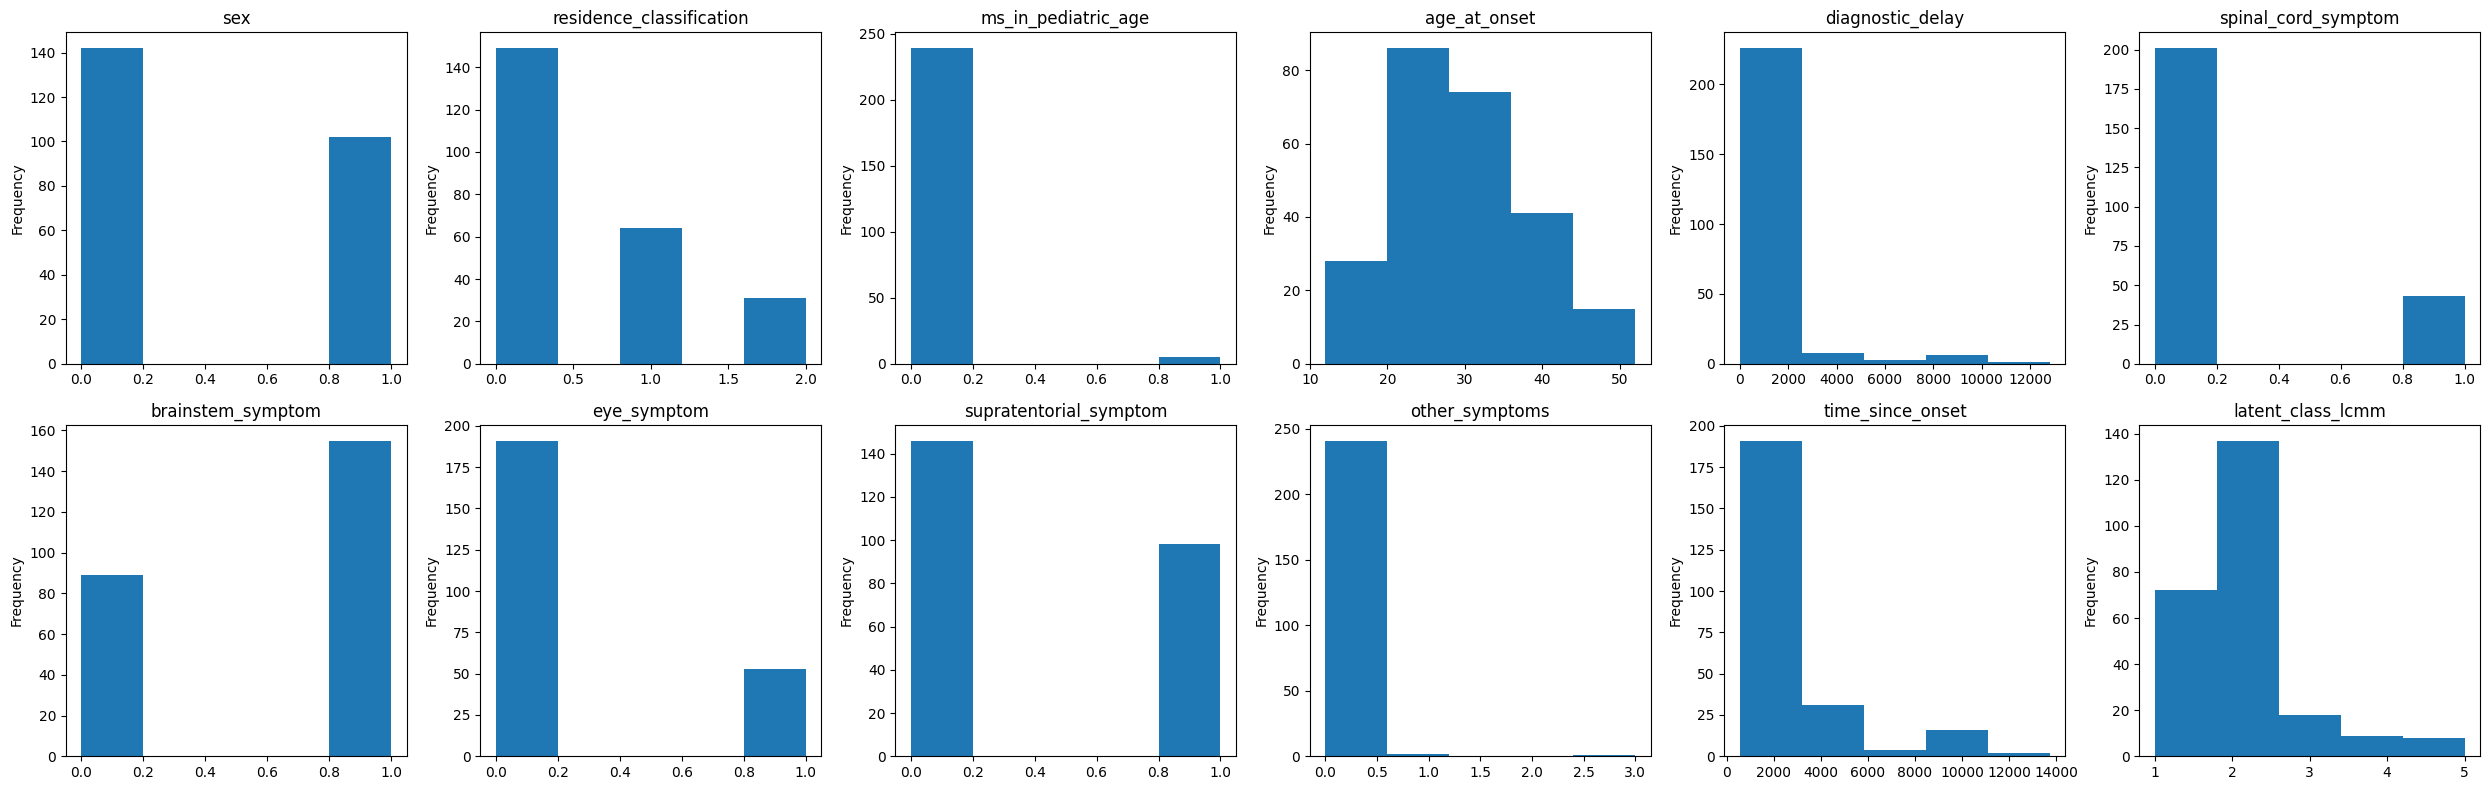

In [14]:
import matplotlib.pyplot as plt
# Creazione dei subplot per gli istogrammi
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 8))

# Iterazione sulle colonne del DataFrame per creare gli istogrammi
for i, col in enumerate(X_train.columns):
    row_index = i // 6
    col_index = i % 6
    ax = axes[row_index, col_index]
    X_train[col].plot.hist(ax=ax, bins=5)
    ax.set_title(col)

# Ottimizzazione del layout
plt.tight_layout()
plt.show()

In [15]:
def normalize_dataset(X, xtrainmin, xtrainmax):
  X = X.astype(float)
  X_norm = np.zeros_like(X, dtype=float)
  for i in range(X.shape[1]):
    if xtrainmin[i] == xtrainmax[i]:
      X_norm[:,i] = X[:,i]
    else:
      X_norm[:,i] = 2*(X[:,i]-xtrainmin[i])/(xtrainmax[i]-xtrainmin[i])-1
  return X_norm

In [16]:
def denormalize_dataset(X_norm, xtrainmin, xtrainmax):
  X_denorm = np.zeros_like(X_norm, dtype=float)
  for i in range(X_norm.shape[1]):
    if xtrainmin[i] == xtrainmax[i]:
      X_denorm[:,i] = X_norm[:,i]
    else:
      X_denorm[:,i] = 0.5*(X_norm[:,i]+1)*(xtrainmax[i]-xtrainmin[i])+xtrainmin[i]
  return X_denorm

In [17]:
#Normalization
X_train_np_min = []
X_train_np_max = []
X_train_np_mean = []
X_train_np_std = []

for i in range(len(X_train_np[0,:])):
  vec = X_train_np[~np.isnan(X_train_np[:,i].astype(float)),i]
  X_train_np_min.append(min(vec))
  X_train_np_max.append(max(vec))

X_train_np = normalize_dataset(X_train_np, X_train_np_min, X_train_np_max)
X_val_np = normalize_dataset(X_val_np, X_train_np_min, X_train_np_max)
X_test_np = normalize_dataset(X_test_np, X_train_np_min, X_train_np_max)

In [18]:
#Train a classifier on the training set
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=1)
clf_lr.fit(X_train_np, y_train_np)

clf = clf_lr

In [19]:
print("CLF Balanced Accuracy\n")
print("Train set:", balanced_accuracy_score(y_train_np, clf.predict(X_train_np)))
print("Val set:  ", balanced_accuracy_score(y_val_np, clf.predict(X_val_np)))
print("Test set: ", balanced_accuracy_score(y_test_np, clf.predict(X_test_np)))

CLF Balanced Accuracy

Train set: 0.7459016393442623
Val set:   0.5225806451612903
Test set:  0.6850490196078431


RELIABILITY ASSESSMENT

In [20]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [21]:
from ReliabilityPackage.ReliabilityFunctions import *

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99
EPOCH 100
EPOCH 101
EPOCH 102
EPOCH 103
EPOCH 104
EPOCH 105
EPOCH 106
EPOCH 107
EPOCH 108
EPOCH 109
EPOCH 110
EPOCH 11

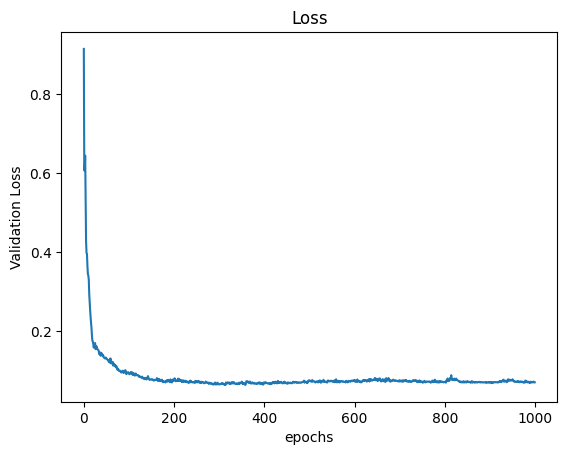

--- 42.446592807769775 seconds ---


In [22]:
#Train an autoencoder on the training set
import time
start_time_ae = time.time()
ae = create_and_train_autoencoder(X_train_np, X_val_np, batchsize=100, epochs=1000, optimizer_params = {'lr': 0.01, 'weight_decay': 1e-8})
print("--- %s seconds ---" % (time.time() - start_time_ae))

In [23]:
#Generate the synthetic points
start_time_syn = time.time()
syn_pts, acc_syn_pts = generate_synthetic_points("classification", clf.predict, X_train_np, y_train_np, method="GN", k = 5)
print("--- %s seconds ---" % (time.time() - start_time_syn))

--- 0.844914436340332 seconds ---


In [24]:
#Define the MSE and the Accuracy thresholds
mse_thresh = perc_mse_threshold(ae, X_train_np, perc=100)
acc_thresh = 0.60

In [25]:
#Implement the reliability method
start_time_rd = time.time()
RD = create_reliability_detector("classification", ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")
print("--- %s seconds ---" % (time.time() - start_time_rd))

--- 19.145541667938232 seconds ---


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
#Compute reliability on the validation and test sets

#Validation set Reliability
val_reliability= compute_dataset_reliability(RD, X_val_np, mode='total')
reliable_val = X_val_np[np.where(val_reliability == 1)]
y_reliable_val = y_val_np[np.where(val_reliability == 1)]
ypred_reliable_val = clf.predict(reliable_val)
unreliable_val = X_val_np[np.where(val_reliability == 0)]
y_unreliable_val = y_val_np[np.where(val_reliability == 0)]
ypred_unreliable_val = clf.predict(unreliable_val)
#Test set Reliability
test_reliability= compute_dataset_reliability(RD, X_test_np, mode='total')
reliable_test = X_test_np[np.where(test_reliability == 1)]
y_reliable_test = y_test_np[np.where(test_reliability == 1)]
ypred_reliable_test = clf.predict(reliable_test)
unreliable_test = X_test_np[np.where(test_reliability == 0)]
y_unreliable_test = y_test_np[np.where(test_reliability == 0)]
ypred_unreliable_test = clf.predict(unreliable_test)

In [27]:
print("Val set:")
print("Reliable:", reliable_val.shape[0], "(","{:.{}f}".format(reliable_val.shape[0]/val_reliability.shape[0]*100, 2),"%)")
print("Unreliable:", unreliable_val.shape[0], "(","{:.{}f}".format(unreliable_val.shape[0]/val_reliability.shape[0]*100, 2),"%)")

print("\nTest set:")
print("Reliable:", reliable_test.shape[0], "(","{:.{}f}".format(reliable_test.shape[0]/test_reliability.shape[0]*100, 2),"%)")
print("Unreliable:", unreliable_test.shape[0], "(","{:.{}f}".format(unreliable_test.shape[0]/test_reliability.shape[0]*100, 2),"%)")

Val set:
Reliable: 7 ( 19.44 %)
Unreliable: 29 ( 80.56 %)

Test set:
Reliable: 37 ( 31.36 %)
Unreliable: 81 ( 68.64 %)


In [28]:
def compute_metrics(y, ypred):
  scores = []
  scores.append(balanced_accuracy_score(y, ypred))
  scores.append(precision_score(y, ypred))
  scores.append(recall_score(y, ypred))
  scores.append(f1_score(y, ypred))
  scores.append(matthews_corrcoef(y, ypred))
  scores.append(average_precision_score(y, ypred))
  scores.append(brier_score_loss(y, ypred))

  return scores

In [29]:
#Function to plot the metrics' plots
def metrics_plots(y, ypred, rel_y, rel_ypred, unrel_y, unrel_ypred, name):
  fig, ax = plt.subplots(figsize=(19, 7))
  xbarplot = np.arange(7)
  y1barplot = compute_metrics(y, ypred)
  y2barplot = compute_metrics(rel_y, rel_ypred)
  y3barplot = compute_metrics(unrel_y, unrel_ypred)

  bar_width = 0.27

  b1 = ax.bar(xbarplot, y1barplot, width = bar_width, color='steelblue')
  b2 = ax.bar(xbarplot+bar_width, y2barplot, width = bar_width, color='lightgreen')
  b3 = ax.bar(xbarplot+2*(bar_width), y3barplot, width = bar_width, color='salmon')

  ax.set_xticks(xbarplot + 2*(bar_width) / 2)
  ax.set_xticklabels(['Balanced Accuracy', 'Precision','Recall', 'f1-score', 'MCC', 'PRC', 'Brier Score'], fontsize=14)
  ax.legend([name,"Reliable "+name, "Unreliable "+name], fontsize=11)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  # Add axis and chart labels.
  ax.set_title('Performance '+name, pad=15, fontsize=18)

  for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = round(bar.get_height(),3)
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = 'black'
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)

  # Set the fontsize for y-axis bar values
  ax.yaxis.set_tick_params(labelsize=10)
  #fig.tight_layout()

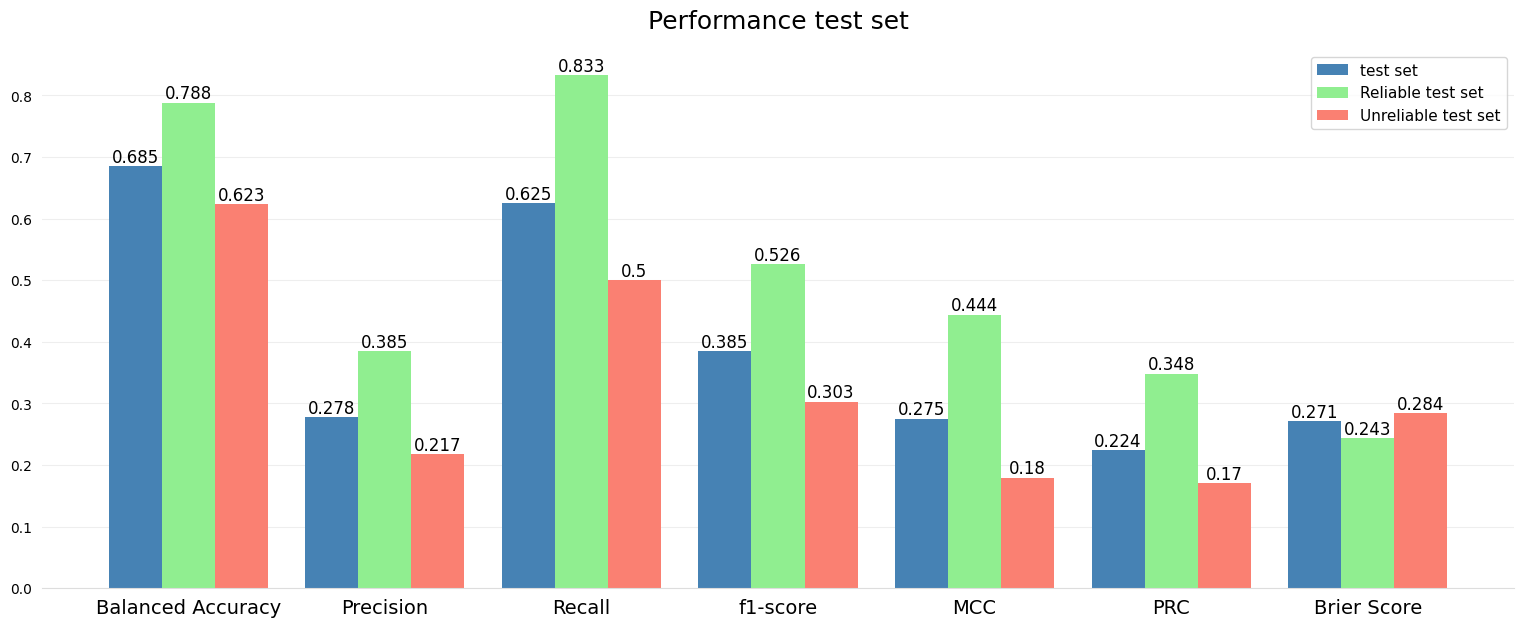

In [30]:
metrics_plots(y_test_np, clf.predict(X_test_np), y_reliable_test, ypred_reliable_test, y_unreliable_test, ypred_unreliable_test,'test set')

In [31]:
#Get a Test df with a column representing reliability

col = [col for col in X_train.columns if col not in ['centre','ethnicity',]]
denorm_reliable_test = denormalize_dataset(reliable_test, X_train_np_min, X_train_np_max)
denorm_unreliable_test = denormalize_dataset(unreliable_test, X_train_np_min, X_train_np_max)

df_test_rel = pd.DataFrame(denorm_reliable_test, columns = col)
df_test_unrel = pd.DataFrame(denorm_unreliable_test, columns = col)

df_test_rel['reliability'] = np.ones(reliable_test.shape[0])
df_test_unrel['reliability'] = np.zeros(unreliable_test.shape[0])
df_test_rel['real_class'] = y_reliable_test
df_test_unrel['real_class'] = y_unreliable_test

df_reliability_test = pd.concat([df_test_rel,df_test_unrel], ignore_index = True)


df_reliability_test.loc[df_reliability_test['sex'] == 0, 'sex'] = 'Female'
df_reliability_test.loc[df_reliability_test['sex'] == 1, 'sex'] = 'Male'

df_reliability_test.loc[df_reliability_test['residence_classification'] == 0, 'residence_classification'] = 'Towns'
df_reliability_test.loc[df_reliability_test['residence_classification'] == 1, 'residence_classification'] = 'Rural Area'
df_reliability_test.loc[df_reliability_test['residence_classification'] == 2, 'residence_classification'] = 'Cities'

In [32]:
#Get the table one

categorical = ['sex', 'residence_classification','ms_in_pediatric_age',
               'spinal_cord_symptom','brainstem_symptom','eye_symptom',
               'supratentorial_symptom','other_symptoms','real_class',
               'latent_class_lcmm']

mytable = TableOne(df_reliability_test, categorical=categorical,  groupby='reliability',
                   pval=True, nonnormal=['diagnostic_delay','time_since_onset'],
                   htest_name = True,) # need to adjust the p-value for residence_classification

print(mytable.tabulate(tablefmt = "fancy_grid"))

╒══════════════════════════════════╤════════════╤═══════════╤═══════════════════════╤═══════════════════════╤═══════════════════════╤═══════════╤═══════════════════════════════════════════╕
│                                  │            │ Missing   │ Overall               │ 0.0                   │ 1.0                   │ P-Value   │ Test                                      │
╞══════════════════════════════════╪════════════╪═══════════╪═══════════════════════╪═══════════════════════╪═══════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ n                                │            │           │ 118                   │ 81                    │ 37                    │           │                                           │
├──────────────────────────────────┼────────────┼───────────┼───────────────────────┼───────────────────────┼───────────────────────┼───────────┼───────────────────────────────────────────┤
│ sex, n (%)                       │ Female     │ 

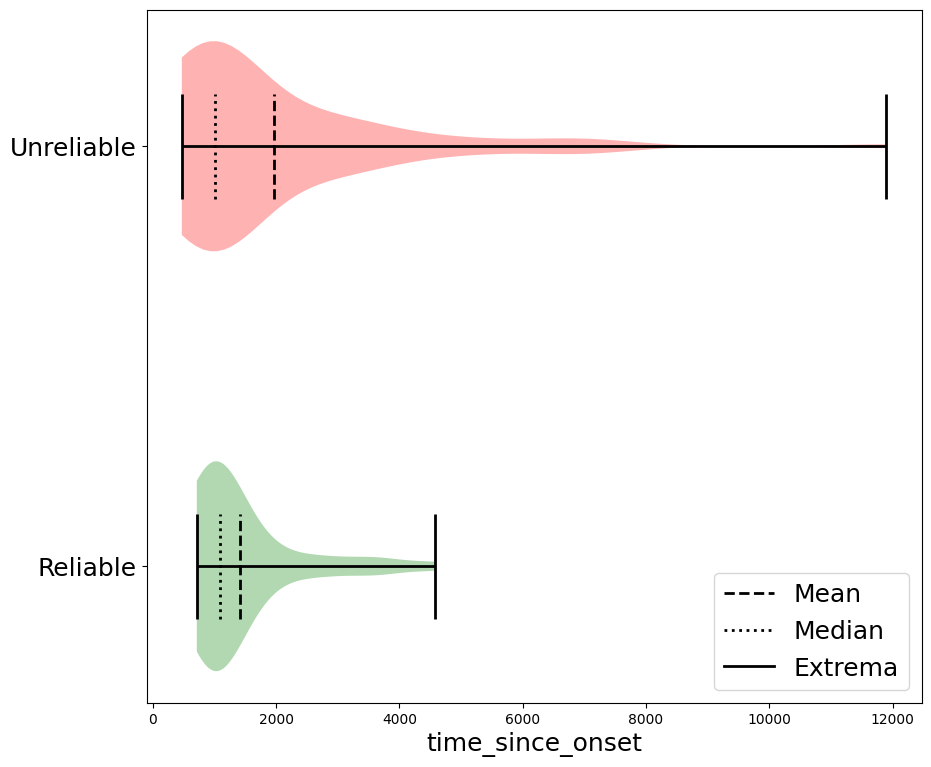

In [33]:
#Violin plots

time_since_onset_rel = [df_test_rel['time_since_onset'], df_test_unrel['time_since_onset']]
# Labels
labels = ['Reliable', 'Unreliable']
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 9))
# Creating horizontal violin plot
vplot = ax.violinplot(time_since_onset_rel, vert=False, showmeans=True, showmedians=True, showextrema=True)
# Customize colors of the violins
colors = ['green', 'red']
for pc, color in zip(vplot['bodies'], colors):
    pc.set_facecolor(color)
# Customize mean and median lines
# Adjust mean lines
vplot['cmeans'].set_linestyle('--')
vplot['cmeans'].set_color('black')
vplot['cmeans'].set_linewidth(2)
# Adjust median lines
vplot['cmedians'].set_linestyle(':')
vplot['cmedians'].set_color('black')
vplot['cmedians'].set_linewidth(2)
# Adjust extrema lines (whiskers and bars)
for partname in ('cmaxes', 'cmins', 'cbars'):
    vplot[partname].set_color('black')
    vplot[partname].set_linewidth(2)
# Add legend to bottom right corner
custom_lines = [
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Mean'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle=':', label='Median'),
    plt.Line2D([0], [0], color='black', lw=2, label='Extrema')
]
ax.legend(handles=custom_lines, fontsize=18, loc='lower right')
# Add labels and title
ax.set_yticks([1, 2])
ax.set_yticklabels(labels, fontsize=18)
ax.set_xlabel('time_since_onset', fontsize=18)
# Show plot
plt.show()

In [35]:
#Sunburst chart

df_reliability_test['eye_symptom'] = df_reliability_test['eye_symptom'].replace({0: 'NO eye symptoms', 1: 'eye symptoms'})
fig = px.sunburst(df_reliability_test, path=['eye_symptom', 'sex', 'residence_classification'],
                  color='reliability',
                  color_continuous_scale='RdYlGn',
                  title='Reliability sunburst plot',
                  width=600,
                  height=600)
# Update layout to increase font size of labels
fig.update_layout(
    font=dict(
        size=14  # Set font size to 20 (adjust as needed)
    )
)
# Show the plot
fig.show()